# **Time Series With LSTM**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
df = pd.read_csv('/content/monthly_milk_production (1).csv',index_col='Date',parse_dates=True)
df.index.freq='MS'

In [7]:
df

,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727
...,...
1975-08-01,858
1975-09-01,817
1975-10-01,827


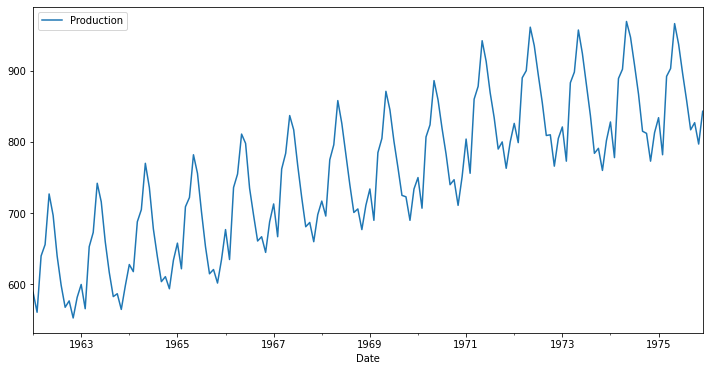

In [8]:
df.plot(figsize=(12,6))

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

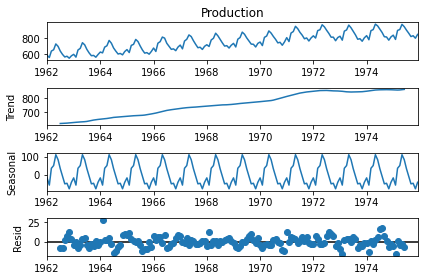

In [10]:
results = seasonal_decompose(df['Production'])
results.plot();

In [11]:
len(df)

168

In [12]:
168-12

156

In [13]:
train = df.iloc[:156]
test = df.iloc[156:]

In [14]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [15]:
df.head()

,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


In [16]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [17]:
scaled_train[:12]

array([[0.08653846],
       [0.01923077],
       [0.20913462],
       [0.24759615],
       [0.41826923],
       [0.34615385],
       [0.20913462],
       [0.11057692],
       [0.03605769],
       [0.05769231],
       [0.        ],
       [0.06971154]])

In [44]:
scaled_test[0]

array([0.67548077])

In [18]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
123 4 --> 345 --> 456 --> 567 --> 567 

In [19]:
# define generator
n_input = 3 #picking 3 bacthes at a time to predict the next batch
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [20]:
X,y = generator[2]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.20913462 0.24759615 0.41826923]
Predict this y: 
 [[0.34615385]]


In [21]:
# We do the same thing, but now instead for 12 months
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [22]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [23]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [25]:
# fit model
model.fit(generator,epochs=50)

Epoch 1/50
144/144 [==============================] - 3s 9ms/step - loss: 0.0453
Epoch 2/50
144/144 [==============================] - 1s 7ms/step - loss: 0.0253
Epoch 3/50
144/144 [==============================] - 1s 7ms/step - loss: 0.0214
Epoch 4/50
144/144 [==============================] - 1s 7ms/step - loss: 0.0138
Epoch 5/50
144/144 [==============================] - 1s 6ms/step - loss: 0.0196
Epoch 6/50
144/144 [==============================] - 1s 7ms/step - loss: 0.0094
Epoch 7/50
144/144 [==============================] - 1s 8ms/step - loss: 0.0064
Epoch 8/50
144/144 [==============================] - 1s 8ms/step - loss: 0.0050
Epoch 9/50
144/144 [==============================] - 2s 10ms/step - loss: 0.0038
Epoch 10/50
144/144 [==============================] - 1s 6ms/step - loss: 0.0040
Epoch 11/50
144/144 [==============================] - 1s 6ms/step - loss: 0.0040
Epoch 12/50
144/144 [==============================] - 1s 6ms/step - loss: 0.0044
Epoch 13/50
144/144 [===

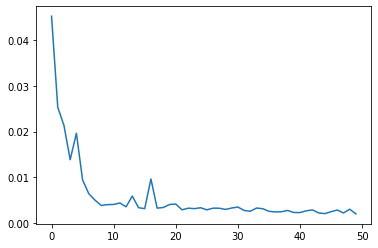

In [26]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

#Make Predictions with LSTM

In [27]:
last_train_batch = scaled_train[-12:] #Using the last 12 months data

In [28]:
last_train_batch

array([[0.66105769],
       [0.54086538],
       [0.80769231],
       [0.83894231],
       [1.        ],
       [0.94711538],
       [0.85336538],
       [0.75480769],
       [0.62980769],
       [0.62259615],
       [0.52884615],
       [0.625     ]])

In [29]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [30]:
last_train_batch 

array([[[0.66105769],
        [0.54086538],
        [0.80769231],
        [0.83894231],
        [1.        ],
        [0.94711538],
        [0.85336538],
        [0.75480769],
        [0.62980769],
        [0.62259615],
        [0.52884615],
        [0.625     ]]])

In [31]:
model.predict(last_train_batch)

1/1 [==============================] - 0s 229ms/step


array([[0.6372659]], dtype=float32)

In [42]:
scaled_test[0]

array([0.67548077])

In [33]:
# above we did for one but here we are looping to see multiple
test_predictions = []

first_eval_batch = scaled_train[-12:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 21ms/step


In [49]:
current_batch[:,1:,:]

array([[[0.59804118],
        [0.79049361],
        [0.86135221],
        [0.98380613],
        [0.97132528],
        [0.89467388],
        [0.78454125],
        [0.66404933],
        [0.62337768],
        [0.56103384],
        [0.59745699]]])

In [34]:
test_predictions

[array([0.6372659], dtype=float32),
 array([0.5980412], dtype=float32),
 array([0.7904936], dtype=float32),
 array([0.8613522], dtype=float32),
 array([0.98380613], dtype=float32),
 array([0.9713253], dtype=float32),
 array([0.8946739], dtype=float32),
 array([0.78454125], dtype=float32),
 array([0.6640493], dtype=float32),
 array([0.6233777], dtype=float32),
 array([0.56103384], dtype=float32),
 array([0.597457], dtype=float32)]

In [35]:
test.head()

,Production
Date,
1975-01-01,834
1975-02-01,782
1975-03-01,892
1975-04-01,903
1975-05-01,966


In [ ]:
test

In [45]:
# we scaled so values are between 0 and 1 now we inverse ann see it to have more idea
true_predictions = scaler.inverse_transform(test_predictions)

In [37]:
test['Predictions'] = true_predictions

<ipython-input-37-920b79c3c314>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [46]:
test.tail()

,Production,Predictions
Date,,
1975-08-01,858,879.369160
1975-09-01,817,829.244520
1975-10-01,827,812.325115
1975-11-01,797,786.390079
1975-12-01,843,801.542109


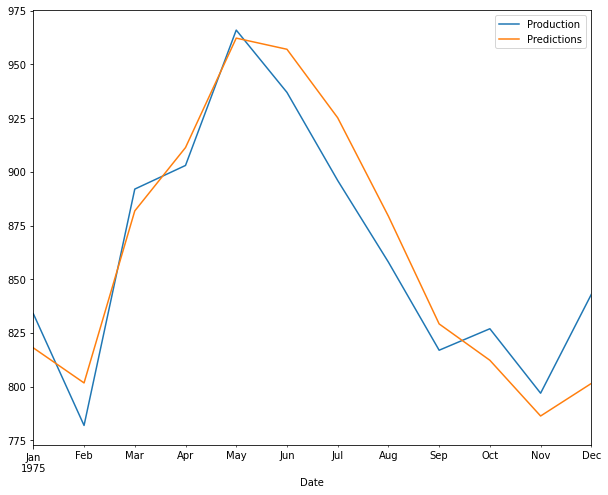

In [39]:
test.plot(figsize=(10,8))

In [40]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['Production'],test['Predictions']))
print(rmse)

19.871155267388716
